# MAGT1 Defficiency Cohort Analysis Report

In [5]:
import gpsea
import hpotk
import pandas as pd
import pyphetools as pyphetools
import glob
from gpsea import *
from gpsea.preprocessing import load_phenopacket_files
from gpsea.preprocessing import configure_caching_cohort_creator

cohort = "TBX1"
tx_id = 'NM_032121.5'
px_id = 'NP_115497.4'

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
cohort_creator = configure_caching_cohort_creator(hpo)


In [6]:
directory_path = 'C:/Users/vladyka47994/OneDrive - Univerzita Karlova/WG Klocperk/Project TBX1 phenopackets/phenopacketsX'

pp_files = glob.glob(f'{directory_path}/*.json')

#print(pp_files)

cohort, qc_results = load_phenopacket_files(pp_files, cohort_creator)


Individuals Processed: 47individuals [00:00, 82.37individuals/s]


## Quality Control

In [9]:
qc_results.summarize()


Validated under none policy
No errors or warnings were found


## Cohort Overview


In [11]:
from gpsea.view import CohortViewable
from IPython.display import display, HTML, IFrame

# Create the cohort report as HTML
viewer = CohortViewable(hpo)
report = viewer.process(cohort=cohort, transcript_id=tx_id)

# Save the report as an HTML file
with open('xmen_cohort_info.html', 'w') as fh:
    _ = fh.write(report)

# Display the report in the notebook
display(IFrame('xmen_cohort_info.html', '100%', '600px'))

## 4. Visualizing the MAGT1 Protein Structure

We visualize the MAGT1 protein structure and save the image.


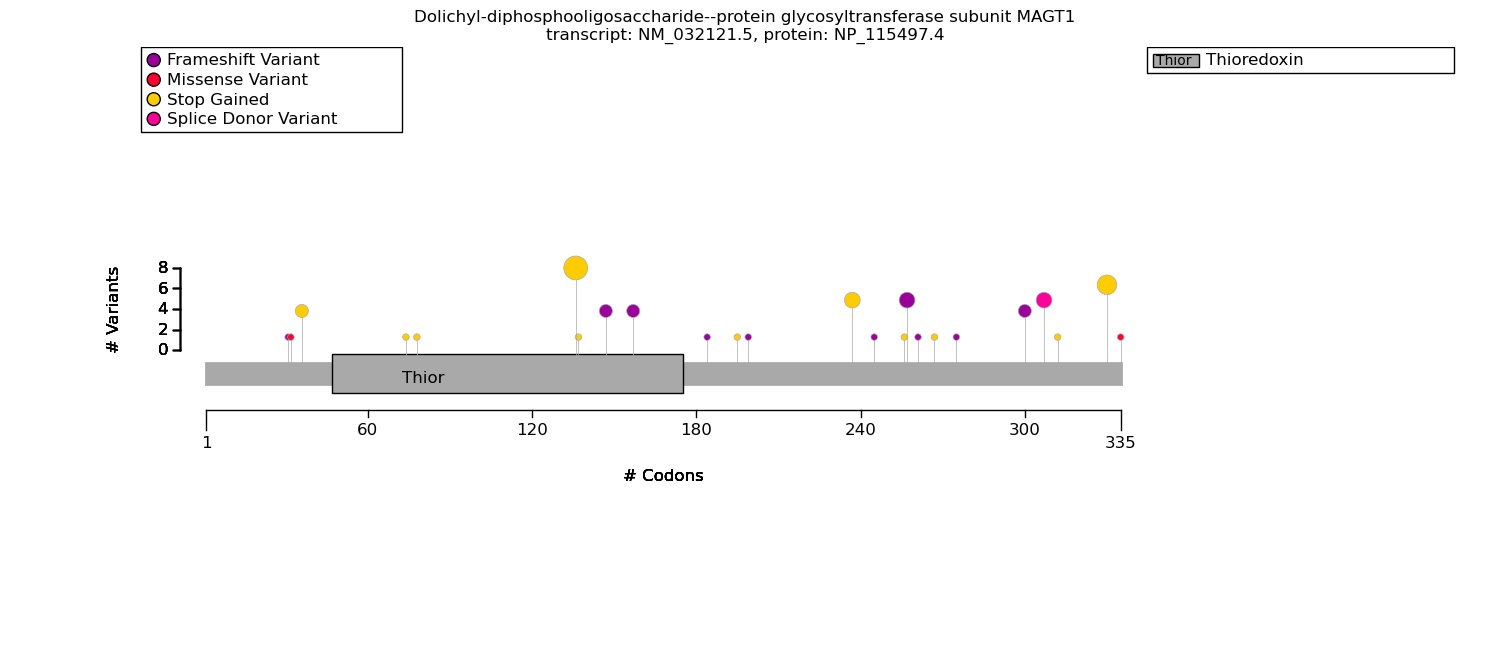

In [55]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(tx_id)
protein_meta = pms.annotate(px_id)


from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()


## Genotype-Phenotype Comparison

We analyze the genotype-phenotype relationships by comparing different variant effects.


In [16]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import *


gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.STOP_GAINED, tx_id), 
                VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id),
    ),
    group_names=("STOP_GAINED", "FRAMESHIFT")
)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=3,
)


In [17]:
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.3)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


In [18]:
from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)


In [19]:
from gpsea.view import summarize_hpo_analysis
import pandas as pd
summary_df = summarize_hpo_analysis(hpo, result)

 # Comparison of 2 main variant classes


In [21]:
display(summary_df)

Genotype group                                     STOP_GAINED          \
                                                         Count Percent   
Abnormal liver enzyme activity or concentration...       16/16    100%   
Persistent EBV viremia [HP:0020072]                      19/24     79%   
Increased B cell count [HP:0005404]                      21/23     91%   
Elevated proportion of CD4-negative, CD8-negati...       11/11    100%   
Otitis media [HP:0000388]                                 1/10     10%   
Acute demyelinating polyneuropathy [HP:0007131]           1/12      8%   
Decreased CD4:CD8 ratio [HP:0033222]                     16/24     67%   
Molluscum contagiosum [HP:0032163]                        4/14     29%   
Decreased circulating IgA concentration [HP:000...       20/23     87%   
Lymphadenopathy [HP:0002716]                             16/22     73%   
Transient neutropenia [HP:0410255]                        9/19     47%   
Lymphoma [HP:0002665]                                    10/22     45%   
Decreased circulating IgG concentration [HP:000...       14/23     61%   
Recurrent sinopulmonary infections [HP:0005425]          17/23     74%   
Thrombocytopenia [HP:0001873]                            12/13     92%   
Elevated circulating creatine kinase concentrat...        7/15     47%   
Decreased proportion of CD4-positive T cells [H...       13/19     68%   
Recurrent aphthous stomatitis [HP:0011107]                5/10     50%   
Splenomegaly [HP:0001744]                                 9/17     53%   
Autoimmune thrombocytopenia [HP:0001973]                  5/13     38%   

Genotype group                                     FRAMESHIFT          \
                                                        Count Percent   
Abnormal liver enzyme activity or concentration...       8/10     80%   
Persistent EBV viremia [HP:0020072]                     12/12    100%   
Increased B cell count [HP:0005404]                      8/12     67%   
Elevated proportion of CD4-negative, CD8-negati...        7/9     78%   
Otitis media [HP:0000388]                                 2/5     40%   
Acute demyelinating polyneuropathy [HP:0007131]           2/6     33%   
Decreased CD4:CD8 ratio [HP:0033222]                    12/14     86%   
Molluscum contagiosum [HP:0032163]                        5/9     56%   
Decreased circulating IgA concentration [HP:000...       9/12     75%   
Lymphadenopathy [HP:0002716]                             7/12     58%   
Transient neutropenia [HP:0410255]                       6/10     60%   
Lymphoma [HP:0002665]                                    7/12     58%   
Decreased circulating IgG concentration [HP:000...       6/12     50%   
Recurrent sinopulmonary infections [HP:0005425]         11/15     73%   
Thrombocytopenia [HP:0001873]                             8/8    100%   
Elevated circulating creatine kinase concentrat...        4/8     50%   
Decreased proportion of CD4-positive T cells [H...       8/11     73%   
Recurrent aphthous stomatitis [HP:0011107]                3/5     60%   
Splenomegaly [HP:0001744]                                5/11     45%   
Autoimmune thrombocytopenia [HP:0001973]                  2/7     29%   

Genotype group                                                         \
                                                   Corrected p values   
Abnormal liver enzyme activity or concentration...           0.767139   
Persistent EBV viremia [HP:0020072]                          0.767139   
Increased B cell count [HP:0005404]                          0.767139   
Elevated proportion of CD4-negative, CD8-negati...           0.767139   
Otitis media [HP:0000388]                                    0.767139   
Acute demyelinating polyneuropathy [HP:0007131]              0.767139   
Decreased CD4:CD8 ratio [HP:0033222]                         0.767139   
Molluscum contagiosum [HP:0032163]                           0.869281   
Decreased circulating IgA concentr

In [22]:
from gpsea.analysis.predicate.genotype import VariantPredicates, groups_predicate
from gpsea.analysis.pcats.stats import FisherExactTest

gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_key('X_77870885_77870885_G_A'), 
                VariantPredicates.variant_key('X_77841252_77841252_G_A'),
    ),
    group_names=("X_77870885_77870885_G_A", "X_77841252_77841252_G_A")
)
gt_predicate.display_question()
'Allele group: A1, A2, A3'

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
        cohort=cohort,
        hpo=hpo,
        min_n_of_patients_with_term=2,
    )

from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05


from gpsea.analysis.pcats.stats import *
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)



142

In [23]:
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_report = mtc_viewer.process(result)
with open('tbx1_variants.mtc_report.html', 'w') as fh:
    _ = fh.write(mtc_report)


from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)

# Comparison of top 2 variants

In [25]:
display(summary_df)

Genotype group                                     X_77870885_77870885_G_A  \
                                                                     Count   
Molluscum contagiosum [HP:0032163]                                     2/8   
Sinusitis [HP:0000246]                                                 2/5   
Opportunistic viral infection [HP:0033432]                             3/8   
Splenomegaly [HP:0001744]                                              4/7   
Lymphadenopathy [HP:0002716]                                           6/8   
Decreased circulating IgA concentration [HP:000...                     6/8   
Elevated circulating creatine kinase concentrat...                     3/5   
Decreased circulating IgG concentration [HP:000...                     6/8   
Recurrent sinopulmonary infections [HP:0005425]                        5/8   
Increased B cell count [HP:0005404]                                    7/8   
Persistent EBV viremia [HP:0020072]                                    7/8   
Decreased proportion of CD4-positive T cells [H...                     5/6   
Lymphoma [HP:0002665]                                                  4/8   
Autoimmune thrombocytopenia [HP:0001973]                               3/7   

Genotype group                                              \
                                                   Percent   
Molluscum contagiosum [HP:0032163]                     25%   
Sinusitis [HP:0000246]                                 40%   
Opportunistic viral infection [HP:0033432]             38%   
Splenomegaly [HP:0001744]                              57%   
Lymphadenopathy [HP:0002716]                           75%   
Decreased circulating IgA concentration [HP:000...     75%   
Elevated circulating creatine kinase concentrat...     60%   
Decreased circulating IgG concentration [HP:000...     75%   
Recurrent sinopulmonary infections [HP:0005425]        62%   
Increased B cell count [HP:0005404]                    88%   
Persistent EBV viremia [HP:0020072]                    88%   
Decreased proportion of CD4-positive T cells [H...     83%   
Lymphoma [HP:0002665]                                  50%   
Autoimmune thrombocytopenia [HP:0001973]               43%   

Genotype group                                     X_77841252_77841252_G_A  \
                                                                     Count   
Molluscum contagiosum [HP:0032163]                                     1/1   
Sinusitis [HP:0000246]                                                 2/2   
Opportunistic viral infection [HP:0033432]                             0/3   
Splenomegaly [HP:0001744]                                              2/2   
Lymphadenopathy [HP:0002716]                                           4/4   
Decreased circulating IgA concentration [HP:000...                     4/4   
Elevated circulating creatine kinase concentrat...                     1/4   
Decreased circulating IgG concentration [HP:000...                     2/4   
Recurrent sinopulmonary infections [HP:0005425]                        3/4   
Increased B cell count [HP:0005404]                                    5/5   
Persistent EBV viremia [HP:0020072]                                    4/5   
Decreased proportion of CD4-positive T cells [H...                     2/3   
Lymphoma [HP:0002665]                                                  1/3   
Autoimmune thrombocytopenia [HP:0001973]                               1/1   

Genotype group                                                                 \
                                                   Percent Corrected p values   
Molluscum contagiosum [HP:0032163]                    100%           0.958081   
Sinusitis [HP:0000246]                                100%           0.958081   
Opportunistic viral infection [HP:0033432]              0%           0.958081   
Splenomegaly [HP:0001744]                             100%           0.958081   
Lymphadenopathy [HP:000

In [26]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

gt_predicate = groups_predicate(
    predicates=(VariantPredicates.variant_effect(VariantEffect.STOP_GAINED, tx_id),
        ~VariantPredicates.variant_effect(VariantEffect.STOP_GAINED, tx_id),
    ),
    group_names=("stop-gained", "other",)
)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
        cohort=cohort,
        hpo=hpo,
        missing_implies_excluded = False,
        min_n_of_patients_with_term=2,
    )

from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('tbx1_5prime_vs_other.csv')


 # Stop gained variants vs all others

In [32]:
display(summary_df)

Genotype group                                     stop-gained          other  \
                                                         Count Percent  Count   
Otitis media [HP:0000388]                                 1/10     10%    6/9   
Cavum septum pellucidum [HP:0002389]                       1/4     25%    3/3   
Persistent EBV viremia [HP:0020072]                      19/24     79%  18/19   
Abnormal liver enzyme activity or concentration...       16/16    100%  12/14   
Verrucae [HP:0200043]                                      2/8     25%   5/10   
Increased B cell count [HP:0005404]                      21/23     91%  14/18   
Elevated proportion of CD4-negative, CD8-negati...       11/11    100%  11/13   
Lymphadenopathy [HP:0002716]                             16/22     73%  10/17   
Decreased CD4:CD8 ratio [HP:0033222]                     16/24     67%  16/20   
Transient neutropenia [HP:0410255]                        9/19     47%   9/15   
Acute demyelinating polyneuropathy [HP:0007131]           1/12      8%   2/10   
Opportunistic viral infection [HP:0033432]                3/20     15%   4/16   
Molluscum contagiosum [HP:0032163]                        4/14     29%   6/14   
Elevated circulating creatine kinase concentrat...        7/15     47%   7/12   
Decreased proportion of CD4-positive T cells [H...       13/19     68%  10/16   
Recurrent sinopulmonary infections [HP:0005425]          17/23     74%  16/21   
Decreased circulating IgA concentration [HP:000...       20/23     87%  14/17   
Decreased circulating IgG concentration [HP:000...       14/23     61%  11/18   
Thrombocytopenia [HP:0001873]                            12/13     92%  11/12   
Sinusitis [HP:0000246]                                    5/10     50%   7/13   
Lymphoma [HP:0002665]                                    10/22     45%   9/18   
Recurrent aphthous stomatitis [HP:0011107]                5/10     50%    3/5   
Splenomegaly [HP:0001744]                                 9/17     53%   8/16   
Autoimmune thrombocytopenia [HP:0001973]                  5/13     38%   4/13   

Genotype group                                                                 \
                                                   Percent Corrected p values   
Otitis media [HP:0000388]                              67%           0.474399   
Cavum septum pellucidum [HP:0002389]                  100%           1.000000   
Persistent EBV viremia [HP:0020072]                    95%           1.000000   
Abnormal liver enzyme activity or concentration...     86%           1.000000   
Verrucae [HP:0200043]                                  50%           1.000000   
Increased B cell count [HP:0005404]                    78%           1.000000   
Elevated proportion of CD4-negative, CD8-negati...     85%           1.000000   
Lymphadenopathy [HP:0002716]                           59%           1.000000   
Decreased CD4:CD8 ratio [HP:0033222]                   80%           1.000000   
Transient neutropenia [HP:0410255]                     60%           1.000000   
Acute demyelinating polyneuropathy [HP:0007131]        20%           1.000000   
Opportunistic viral infection [HP:0033432]             25%           1.000000   
Molluscum contagiosum [HP:0032163]                     43%           1.000000   
Elevated circulating creatine kinase concentrat...     58%           1.000000   
Decreased proportion of CD4-positive T cells [H...     62%           1.000000   
Recurrent sinopulmonary infections [HP:0005425]        76%           1.000000   
Decreased circulating IgA concentration [HP:000...     82%           1.000000   
Decreased circulating IgG concentration [HP:000...     61%           1.000000   
Thrombocytopenia [HP:0001873]                          92%           1.000000   
Sinusitis [HP:0000246]                                 54%           1.000000   
Lymphoma [HP:0002665]                                  50%           1.000000   
Recurrent aphthous stomatitis 

In [36]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import *
from gpsea.model.genome import *



gt_predicate = groups_predicate(
    predicates=(
        VariantPredicates.region(region = Region(1, 175), tx_id='NM_032121.5'),
        VariantPredicates.region(region = Region(176, 335), tx_id='NM_032121.5'),
    ),
    group_names=("Before or including Thioredoxine region", "After Thioredoxine region")
)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
        cohort=cohort,
        hpo=hpo,
        missing_implies_excluded = False,
        min_n_of_patients_with_term=2,
    )

from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05


from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()


from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import summarize_hpo_analysis
import pandas as pd

# Summarize the HPO analysis into a DataFrame
summary_df = summarize_hpo_analysis(hpo, result)

# Save to CSV file
summary_df.to_csv('magt1_5prime_vs_other.csv')


In [37]:
display(summary_df)

Genotype group                                     Before or including Thioredoxine region  \
                                                                                     Count   
Transient neutropenia [HP:0410255]                                                    5/15   
Lymphadenopathy [HP:0002716]                                                          9/17   
Molluscum contagiosum [HP:0032163]                                                    3/14   
Otitis media [HP:0000388]                                                              1/9   
Recurrent aphthous stomatitis [HP:0011107]                                             2/7   
Verrucae [HP:0200043]                                                                 2/10   
Thrombocytopenia [HP:0001873]                                                         9/11   
Lymphoma [HP:0002665]                                                                 6/17   
Decreased circulating IgA concentration [HP:000...                                   12/16   
Splenomegaly [HP:0001744]                                                             6/15   
Autoimmune thrombocytopenia [HP:0001973]                                              4/14   
Decreased proportion of CD4-positive T cells [H...                                    8/13   
Decreased CD4:CD8 ratio [HP:0033222]                                                 13/19   
Elevated proportion of CD4-negative, CD8-negati...                                   10/12   
Persistent EBV viremia [HP:0020072]                                                  14/17   
Decreased circulating IgG concentration [HP:000...                                   11/17   
Recurrent sinopulmonary infections [HP:0005425]                                      14/19   
Abnormal liver enzyme activity or concentration...                                   13/14   
Increased B cell count [HP:0005404]                                                  14/16   
Elevated circulating creatine kinase concentrat...                                    5/11   
Sinusitis [HP:0000246]                                                                7/12   
Opportunistic viral infection [HP:0033432]                                            3/16   
Cavum septum pellucidum [HP:0002389]                                                   1/2   

Genotype group                                              \
                                                   Percent   
Transient neutropenia [HP:0410255]                     33%   
Lymphadenopathy [HP:0002716]                           53%   
Molluscum contagiosum [HP:0032163]                     21%   
Otitis media [HP:0000388]                              11%   
Recurrent aphthous stomatitis [HP:0011107]             29%   
Verrucae [HP:0200043]                                  20%   
Thrombocytopenia [HP:0001873]                          82%   
Lymphoma [HP:0002665]                                  35%   
Decreased circulating IgA concentration [HP:000...     75%   
Splenomegaly [HP:0001744]                              40%   
Autoimmune thrombocytopenia [HP:0001973]               29%   
Decreased proportion of CD4-positive T cells [H...     62%   
Decreased CD4:CD8 ratio [HP:0033222]                   68%   
Elevated proportion of CD4-negative, CD8-negati...     83%   
Persistent EBV viremia [HP:0020072]                    82%   
Decreased circulating IgG concentration [HP:000...     65%   
Recurrent sinopulmonary infections [HP:0005425]        74%   
Abnormal liver enzyme activity or concentration...     93%   
Increased B cell count [HP:0005404]                    88%   
Elevated circulating creatine kinase concentrat...     45%   
Sinusitis [HP:0000246]                                 58%   
Opportunistic viral infection [HP:0033432]             19%   
Cavum septum pellucidum [HP:0002389]                   50%   

Genotype group                                     After Thioredoxine region  \
                  

### Comment

The magnesium transporter 1 (MAGT1) is an Mg<sup>2+</sup>-specific ion transporter which mediates a transient influx of Mg<sup>2+</sup> into T-cells and natural killer (NK) cells during activation, playing a crucial role in immune signaling and function [1].  Hemizygous loss-of-function variants in MAGT1 gene are associated with X-linked immunodeficiency with magnesium defect, Epstein-Barr virus (EBV) infection, and neoplasia (XMEN) disease [2, 3]. Patients with XMEN often suffer from recurrent ear and sinopulmonary infections, as well as repeated viral infections (Herpes simplex, Molluscum contagiosum). Clinical manifestations also often include chronic lymphadenopathy, splenomegaly, and an increased risk of EBV-associated B-cell malignancies [4].
In our analysis, we compiled data from 47 patients reported in the published literature, annotated their clinical features using HPO terms, created Phenopackets [5], and then performed a GPSEA analysis. Overall, we identified 28 disease-causing variants in the transcript NM_032121.5 of the MAGT1 gene distributed across all exons of the gene (Figure 1). Clinical features in patients were annotated with 22 distinct HPO terms.


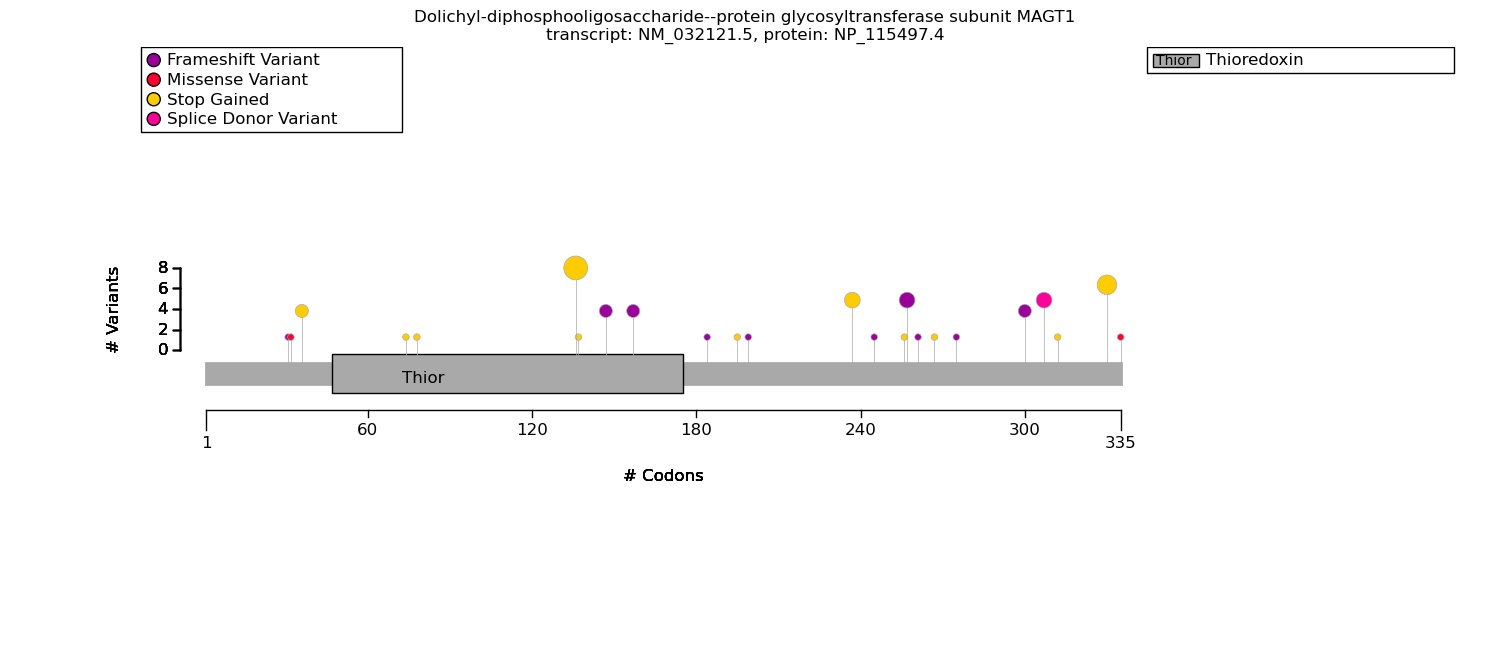

In [61]:
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

*Figure 1: Structure and variants identified in the MAGT1 gene*

When comparing the main variant classes across all annotated HPO terms, no significant associations were found. In a subsequent comparison between the most frequent type of variants, stop-gain (n=25), and the combined other variants group (n=22), otitis media (HPO:0000388) seemed to be significantly associated with “other” variants (p = 0.01). However, this association became insignificant after adjustment for multiple comparisons (p = 0.47). 
Comparison of the two most frequently occurring disease-causing variants in the patient cohort also revealed no significant association with any of the annotated HPO terms. It is likely that both stop-gain and frameshift variants lead to the synthesis of a non-functional protein, or undergo nonsense mediated decay, resulting in RNA degradation and the absence of protein production, thus abrogating any potential difference in clinical penetrance.
Finally, assuming the formation of a truncated protein, it was relevant to focus on the location of stop-gain variants. Nevertheless, a comparison between patients with variants located upstream or within the Thioredoxin domain and those with variants retaining the Thioredoxin domain, and possibly its function, showed no significant association. This finding is consistent with the hypothesis that no variant in this cohort actually produces a functional protein, suggesting their functional impact is likely similar.
References

1.	Li F. Y., Lenardo M. J., and Chaigne-Delalande B. Loss of MAGT1 abrogates the Mg<sup>2+</sup> flux required for T cell signaling and leads to a novel human primary immunodeficiency, Magnesium Research. (2011) 24(3), 109-114, https://doi.org/10.1684/mrh.2011.0286. 
2.	Trapani V., Shomer N., and Rajcan-Separovic E. The role of MAGT1 in genetic syndromes,  Magnesium Research. (2015) 28(2), 46-55, 
3.	Li F. Y., Chaigne-Delalande B., Su H., Uzel G., Matthews H., and Lenardo M. J. XMEN disease: a new primary immunodeficiency affecting Mg2+ regulation of immunity against Epstein-Barr virus. Blood. (2014) 123(14), 2148-2152, https://doi.org/10.1182/blood-2013-11-538686. 
4.	Patiroglu T., Haluk Akar H., Gilmour K., Unal E., Akif Ozdemir M., Bibi S., Burns S., Chiang S. C., Schlums H., Bryceson Y. T., and Karakukcu M. A case of XMEN syndrome presented with severe auto-immune disorders mimicking autoimmune lymphoproliferative disease, Clinical Immunology. (2015) 159(1), 58-62, https://doi.org/10.1016/j.clim.2015.04.015. 
5.	Danis D., Bamshad MJ., Bridges Y., Caballero-Oteyza A., Cacheiro P., Carmody LC., et al. A corpus of GA4GH phenopackets: case-level phenotyping for genomic diagnostics and discovery. HGG Adv (2024):100371. https://doi.org/10.1016/j.xhgg.2024.100371


